# Principal Component Analysis

PCA is a dimensionality reduction technique that aims to create "principal components" consisting of the most important features of a high-dimensional dataset. Our desired outcome is to project a feature space onto a smaller subspace that represents our data "well"

**How does PCA determine what features contain the most information?**
By measuring *variation* (or how different a feature is from another) as a proxy for information.

**How does measuring variation make sense?**
When two features are correlated, it doesn't make sense to include them both in a model, because *you only need one to capture the information of both*. In PCA, we remove features if they contribute very little variation. 

### PCA Vs. Multiple Discriminant Analysis (MCA)
MDA and PCA are both linear transformation methods that closely relate to one another. In PCA, we are interested in finding the directions (components) that maximize the variance in our dataset, where in MDA, we are additionally interested to find the directions that maximize the separation (or discrimination) between different classes. I.e. in pattern classification problems where our dataset consists of multiple classes, in contrast to PCA which ignores the class labels.

In other words, via PCA, we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classe. Roughly speaking, in PCA we are trying to find the axes with maximum variance where the data is most spread (within a class, since PCA treats the whole dataset as one class), and in MDA we are additionaly maximizing the spread between classes. In pattern recognition problems, a PCA is often followed by an MDA.

### What's a good subspace?
Assuming our goal is to reduce the dimensions of a d-dimensional dataset by projecting it onto a k-dimensional space (where k < d). Later, we will compute eigenvectors (the components) from our dataset and collect them in a so-called scatter-matrix (or alternatively calculate them from the covariance matrix). Each of those eigenvectors is associated with an eigenvalue, which tell us about the "length" or "magnitude" of the eigenvectors. If we observe that all the eigenvalues are of very similar magnitude, this is a good indicator that our data is already in a "good" subspace. Or if some of the eigenvalues are much much higher than others, we might be interested in only keeping those eigenvectors with much larger eigenvalues, since they contain more information about our data distribution. Vice verse, eigenvalues that are close to 0 are less informative and we might consider dropping those when we construct the new feature subspace.

## Summarizing PCA Steps
1. Take the whole dataset consisting of d-dimensional samples, ignoring class labels
2. Compute the d-dimensional mean vector (i.e., the means for every dimension of the whole dataset)
3. Compute the scatter matrix (alternatively, the covariance matrix) of the whole dataset
4. Compute eigenvectors ($e_1, e_2, ..., e_d$) and corresponding eigenvalues ($\lambda_1, \lambda_2, ..., \lambda_d$)
5. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $ d \times k$ dimensional matrix $W$ (where every column represents an eigenvector)
6. Use this $d×k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $y = W^T \times x$ (where $x$ is a $d × 1$-dimensional vector representing one sample, and $y$ is the transformed $k×1$-dimensional sample in the new subspace.)

## Generating some 3-dimensional sample data
For the following example, we will generate 40 3-dimensional samples randomly drawn from a multivariate Gaussian distribution.
Here, we will assume that the samples stem from two different classes, where one half (i.e., 20) samples of our data set are labeled $ω1$ (class 1) and the other half $ω2$ (class 2).

We're using 3-dimensional data because it's intuitive and visually appealing.

In [1]:
import numpy as np

np.random.seed(100)

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

The code above created two $3 \times 20$ - one for $ω1$ and one for $ω2$ - where each column can be pictured as a 3-dimensional vector $x$.

Let's plot the data:

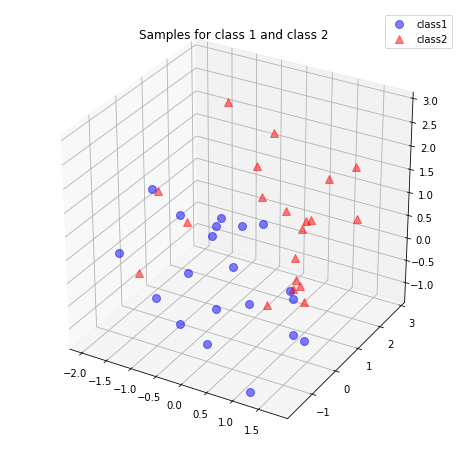

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

## Step 1: Taking the whole dataset ignoring the class labels
Because we don't need class labels for PCA, lets merge the samples for our 2 classes into one $3 \times 40$-dimensional array:

In [4]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"

## Step 2: Computing the d-dimensional mean vector

In [5]:
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[0.27690942]
 [0.16338524]
 [0.52376228]]


## 3a) Computing the Scatter Matrix

The scatter matrix is computed by the following equation: $S = \sum^{n}_{k=1}(x_k - m)(x_k - m)^T$ where $m$ is the mean vector: $m = \frac{1}{n} \sum^{n}_{k=1} x_k$

In [6]:
scatter_matrix = np.zeros((3,3))
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:,i].reshape(3,1) - mean_vector).dot((all_samples[:,i].reshape(3,1) - mean_vector).T)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[44.50973415  1.15638979  2.51321586]
 [ 1.15638979 41.07702036  9.69812231]
 [ 2.51321586  9.69812231 48.44117732]]


## 3b) Computing the Covariance Matrix

Alternatively, we could also calculate the covariance matrix using the in-built `numpy.cov()` function. The equation here is very similar, the only difference is that we use the scaling factor $\frac{1}{N-1}$ (here $\frac{1}{40-1} = \frac{1}{39}$) for the covariance matrix. Thus, their **eigenspaces** will be identical.

In [7]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[1.14127523 0.02965102 0.06444143]
 [0.02965102 1.05325693 0.2486698 ]
 [0.06444143 0.2486698  1.24208147]]


## Step 4) Computing eigenvectors and corresponding eigenvalues

To show that the eigenvectors are indeed identical whether we derived them from the scatter or the covariance matrix, let us put an `assert` statement into the code. Also, we will see that the eigenvalues were indeed scaled by the factor 39 when we derived it from the scatter matrix.

In [8]:
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'

    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

Eigenvector 1: 
[[0.23501674]
 [0.54770272]
 [0.80298746]]
Eigenvalue 1 from scatter matrix: 55.79164799098635
Eigenvalue 1 from covariance matrix: 1.430555076691957
Scaling factor:  39.000000000000014
----------------------------------------
Eigenvector 2: 
[[ 0.97078   ]
 [-0.17349458]
 [-0.16578852]]
Eigenvalue 2 from scatter matrix: 43.873864333761766
Eigenvalue 2 from covariance matrix: 1.1249708803528662
Scaling factor:  38.999999999999986
----------------------------------------
Eigenvector 3: 
[[-0.04851115]
 [-0.81848724]
 [ 0.57247297]]
Eigenvalue 3 from scatter matrix: 34.362419508935936
Eigenvalue 3 from covariance matrix: 0.8810876797163062
Scaling factor:  38.99999999999999
----------------------------------------


### Checking the eigenvector-eigenvalue calculation

Let us quickly check the eigenvector-eigenvalue calculation is correct and satisfy the equation
$$
\sum v = \lambda v
$$

where
$$\sum = Covariance;matrix$$
$$v = Eigenvector$$
$$\lambda = Eigenvalue$$

In [9]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:,i].reshape(1,3).T
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eigv), eig_val_sc[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

### Visualizing the eigenvalues

Let's plot the eigenvectors centered at the sample mean

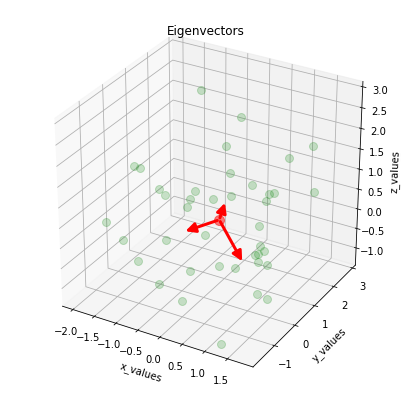

In [10]:
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

## Step 5.1) Sorting the eigenvectors by decreasing eigenvalues

We started with the goal of reducing the dimensionality of our feature space, i.e., projecting the feature space via PCA onto a smaller subspace, where the eigenvectors will form the axes of this new feature subspace. However, the iegenvectors only define the directions of the new axis, since they all have the same unit length 1.

So, in order to decide which eigenvectors we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.

The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top $k$ eigenvectors.

In [11]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

55.79164799098635
43.873864333761766
34.362419508935936


The first output is the Principal Component with the largest variance - the direction in which the data varies most.

## Step 5.2) Choosing $k$ eigenvectors with the largest eigenvalues

For our simple example, we are combining the two eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $W$

In [12]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.23501674  0.97078   ]
 [ 0.54770272 -0.17349458]
 [ 0.80298746 -0.16578852]]


One common approach to selecting the number of components is to plot number of components and % of variance explained, called the "Elbow Method:
![elbow](https://miro.medium.com/max/850/1*9ihLnBj-RV2h4e-VEimEbw.png)

## Tranforming the samples onto the new subspace

In this last step, we use the $2 \times 3$-dimensional matrix $W$ that we just computed to transform our samples onto the new subspace via the equation $y = W^T \times x$

In [13]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."

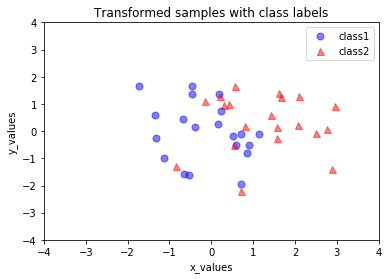

In [14]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

## Using the `PCA()` class from the `sklearn.decomposition` library

For our convenience we can directly specify how many components we want to reduce our input dataset to via the `n_components` parameter:

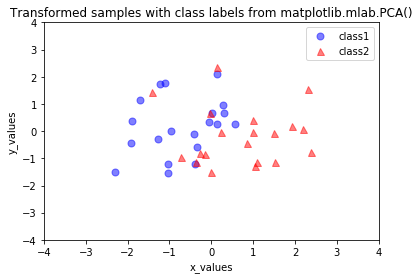

In [16]:
from sklearn.decomposition import PCA

sklearn_PCA = PCA(n_components=2)
sklearn_transf = sklearn_PCA.fit_transform(all_samples.T)

plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

The plot above seems to be the exact mirror image of the plot from our step-by-step approach.

Thanks to [this post](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html) by Sebastian Raschka for the tutorial.